# Spectral analysis of the Matern family of covariance functions

In [1]:
import numpy as np
import gstools as gs
import scipy.special as sps
from scipy.fft import fft, ifft

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

import matplotlib.pyplot as plt

## Simple demo

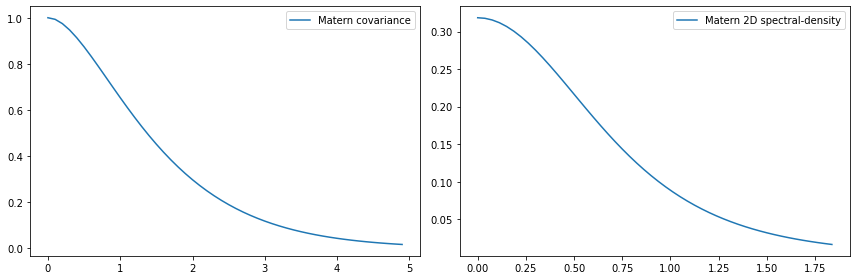

In [2]:
## Construct standard Matern Kernel, plot it's covariance and spectrum
model = gs.Matern(dim=2, var=1, nu=1.5)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
model.plot("covariance", ax=ax[0])
model.plot("spectral_density", ax=ax[1])
plt.tight_layout();

## Analysis

In [3]:
## Parameters
dim = 1
sig = 1
nu = 1.5
ell = 1.5

### GS Tools approach

In [4]:
## Classical Matern
class MaternClassic(gs.CovModel):
    def default_opt_arg(self):
        return {"nu": 1.5}

    def cor(self, r):
        r = np.array(np.abs(r), dtype=np.double)
        # calculate by log-transformation to prevent numerical errors
        r_gz = r[r > 0.0]
        res = np.ones_like(r)
        # with np.errstate(over="ignore", invalid="ignore"):
        res[r > 0.0] = np.exp(
            (1.0 - self.nu) * np.log(2)
            - sps.loggamma(self.nu)
            + self.nu * np.log(r_gz / self.len_scale)
        ) * sps.kv(self.nu, r_gz / self.len_scale)
        # if nu >> 1 we get errors for the farfield, there 0 is approached
        res[np.logical_not(np.isfinite(res))] = 0.0
        # covariance is positiv
        res = np.maximum(res, 0.0)
        return res
    
## Machine Learning Matern
class MaternML(gs.CovModel):
    def default_opt_arg(self):
        return {"nu": 1.5}

    def cor(self, r):
        r = np.array(np.abs(r), dtype=np.double)
        # calculate by log-transformation to prevent numerical errors
        r_gz = r[r > 0.0]
        res = np.ones_like(r)
        # with np.errstate(over="ignore", invalid="ignore"):
        res[r > 0.0] = np.exp(
            (1.0 - self.nu) * np.log(2)
            - sps.loggamma(self.nu)
            + self.nu * np.log(np.sqrt(2.0*self.nu) * r_gz / self.len_scale)
        ) * sps.kv(self.nu, np.sqrt(2.0*self.nu) * r_gz / self.len_scale)
        # if nu >> 1 we get errors for the farfield, there 0 is approached
        res[np.logical_not(np.isfinite(res))] = 0.0
        # covariance is positiv
        res = np.maximum(res, 0.0)
        return res

In [5]:
model_default = gs.Matern(dim=dim, nu=nu, len_scale=ell/np.sqrt(2))
model_classic = MaternClassic(dim=dim, nu=nu, len_scale=ell/np.sqrt(2*nu))
model_ml = MaternML(dim=dim, nu=nu, len_scale=ell)

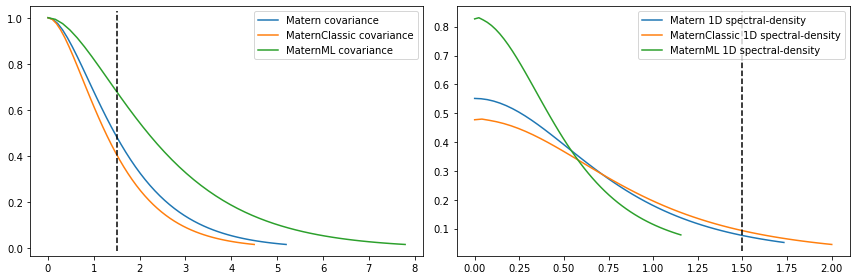

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

model_default.plot("covariance", ax=ax[0])
model_classic.plot("covariance", ax=ax[0])
model_ml.plot("covariance", ax=ax[0])
ax[0].axvline(x=ell, ymin=0.02, ymax=0.98, color="black", linestyle="dashed")

model_default.plot("spectral_density", ax=ax[1])
model_classic.plot("spectral_density", ax=ax[1])
model_ml.plot("spectral_density", ax=ax[1])
ax[1].axvline(x=ell, ymin=0.02, ymax=0.98, color="black", linestyle="dashed")


plt.tight_layout()
# plt.savefig("../plots/matern_spectral_analysis.png")

### Direct approach

In [7]:
## Custom covariance functions
def cov_classic(h, nu, len_scale):
    return (2**(1-nu) / sps.gamma(nu)) * (h / len_scale)**nu * sps.kv(nu, h / len_scale)
    
def cov_RW(h, nu, len_scale):
    return (2**(1-nu) / sps.gamma(nu)) * (np.sqrt(2*nu) * h / len_scale)**nu * sps.kv(nu, np.sqrt(2*nu) * h / len_scale)


## Custom density functions
def density_CW(omega, dim, nu, len_scale):
    return (len_scale**dim / np.pi**(dim/2)) * (sps.gamma(nu + dim/2) / sps.gamma(nu)) * (1 + len_scale**2 * omega**2)**(-nu - dim/2)

def density_GKS(omega, dim, nu, len_scale):
    return (1 / (len_scale**(2*nu) * np.pi**(dim/2))) * (sps.gamma(nu + dim/2) / sps.gamma(nu)) * (len_scale**(-2) + omega**2)**(-nu - dim/2)
    
def density_RW(omega, dim, nu, len_scale):
    return 2**dim * np.pi**(dim/2) * (2*nu / (len_scale**2))**nu * (sps.gamma(nu + dim/2) / sps.gamma(nu)) * ((2*nu / (len_scale**2)) + 4*np.pi**2 * omega**2)**(-nu - dim/2)

In [8]:
domain = np.linspace(0, 4, 100)

# k_classic = cov_classic(domain, nu, ell/np.sqrt(2*nu))
k_classic = cov_classic(domain, nu, ell)
k_RW = cov_RW(domain, nu, ell)

spec_CW = density_CW(domain, dim, nu, ell)
spec_GKS = density_GKS(domain, dim, nu, ell)
spec_RW = density_RW(domain, dim, nu, ell)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


In [9]:
## https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py
# kernel = Matern(length_scale=ell, nu=nu)
# gp = GaussianProcessRegressor(kernel=kernel)

# X_ = domain
# sample = gp.sample_y(X_[:, np.newaxis]).flatten()

# np.real(fft(sample))

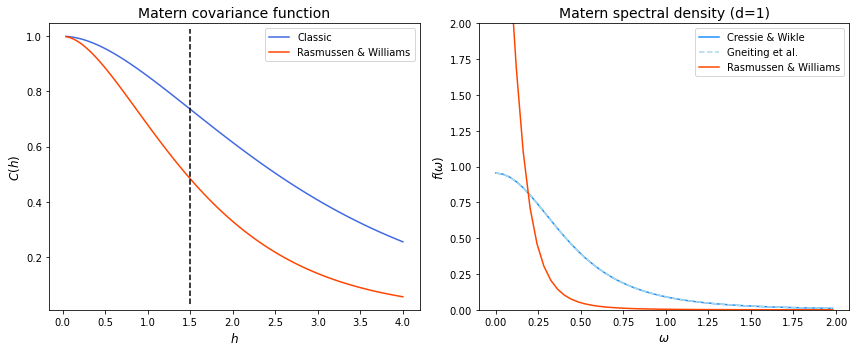

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].set_title("Matern covariance function", size=14)
ax[0].plot(domain, k_classic, color="royalblue", label="Classic")
ax[0].plot(domain, k_RW, color="orangered", label="Rasmussen & Williams")
# ax[0].plot(domain, np.real(ifft(spec_GKS)), color="gold", label="IFFT")
# ax[0].plot(domain, sample, color="green")
ax[0].axvline(x=ell, ymin=0.02, ymax=0.98, color="black", linestyle="dashed")
ax[0].set_xlabel("$h$", size=12)
ax[0].set_ylabel("$C(h)$", size=12)
ax[0].legend()

ax[1].set_title(f"Matern spectral density (d={dim})", size=14)
ax[1].plot(domain[:50], spec_CW[:50], color="dodgerblue", label="Cressie & Wikle")
ax[1].plot(domain[:50], spec_GKS[:50], color="lightblue", label="Gneiting et al.", linestyle="dashed")
ax[1].plot(domain[:50], spec_RW[:50], color="orangered", label="Rasmussen & Williams")

# ax[1].plot(domain, np.real(fft(k_classic)), color="blueviolet", label="FFT of classic form")
# ax[1].plot(domain, np.real(fft(k_RW)), color="gold", label="FFT of R&W form")
# ax[1].plot(domain, np.real(fft(sample)), color="gold", label="FFT of sample process")
ax[1].set_ylim([0, 2])
ax[1].set_xlabel("$\omega$", size=12)
ax[1].set_ylabel("$f(\omega)$", size=12)
ax[1].legend()


plt.tight_layout()
# plt.savefig("../plots/matern_spectral_analysis.png")